### Solve $\nabla^2 x = b$

Initialization finished.


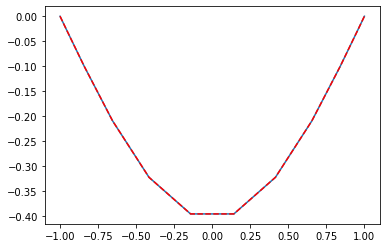

In [9]:
import numpy as np
from pypde.bases.chebyshev import *
from numpy.linalg import solve
from pypde.solver.matrix import *
from pypde.solver.operator import *
import matplotlib.pyplot as plt

def f(x):
    return np.cos(1*np.pi/2*x)

def usol(x):
    return -np.cos(1*np.pi/2*x)*(1*np.pi/2)**-2

class Poisson():
    def __init__(self,f,N):
        self.N  = N
        self.xf = ChebDirichlet(self.N+2,bc=(0,0))   # Basis in x
        self.x  = self.xf.x                          # X-coordinates

        # -- Matrices ------
        D = Chebyshev(self.N+2).D(2)     # Spectral derivative matrix
        B = Chebyshev(self.N+2).B(2)     # Pseudo inverse of D
        S = self.xf.S                    # Transform stencil Galerkin--> Chebyshev
        M =  (B@S)[2:,:]
        D2 = (B@D@S)[2:,:]

        # -- RHS ---
        fhat = self.xf.forward_fft(f)
        self.b = RHSExplicit(f=fhat)
        self.b.add_PM(MatrixRHS(M,axis=0))

        # -- LHS ---
        A =  D2
        A0 = MatrixLHS(A,ndim=1,axis=0,
            solver="solve")                 # Use numpy.linalg.solve
        A1 = MatrixLHS(A,ndim=1,axis=0,
            solver="tdma")                  # Use diagonal solver
        self.A0 = LHSImplicit(A0)
        self.A1 = LHSImplicit(A1)

        # -- Solution ----
        #self.sol = self.usol(self.x)
        #self.solhat = self.xf.forward_fft(self.sol)

        print("Initialization finished.") 
        
    def solve(self):
        uhat = self.A0.solve(self.b.rhs)
        u = self.xf.backward_fft(uhat)
        #u = self.xf.backward_fft(u.T).T
        return u
        
N = 10
xf = ChebDirichlet(N+2,bc=(0,0))
x = xf.x
P = Poisson(f(x),N)
u = P.solve()

plt.plot(x,u)
plt.plot(x,usol(x),"r--")
plt.show()

In [129]:
import numpy as np
from pypde.bases.chebyshev import *
from numpy.linalg import solve
from pypde.solver.matrix import *
from pypde.solver.operator import *
import matplotlib.pyplot as plt

ARG = np.pi/2
def f(xx,yy):
    return np.cos(ARG*xx)*np.cos(ARG*yy)

def usol(xx,yy):
    return f(xx,yy)*-1/ARG**2/2

class Poisson2D():
    def __init__(self,f,N):
        assert f.ndim==2
        self.N  = N
        self.xf = ChebDirichlet(self.N+2,bc=(0,0))   # Basis in x
        self.x  = self.xf.x                          # X-coordinates

        # -- Matrices ------
        D = Chebyshev(self.N+2).D(2)     # Spectral derivative matrix
        B = Chebyshev(self.N+2).B(2)     # Pseudo inverse of D
        S = self.xf.S                    # Transform stencil Galerkin--> Chebyshev
        M =  (B@S)[2:,:]
        D2 = (B@D@S)[2:,:]
        self.B = B[2:,:]
        
        self.M = M
        self.D = D2
        print(S.shape)
        
        # -- Eigendecomposition ---
        Mi = np.linalg.inv(M)
        self.eigdecomp(D2.T@Mi.T)
        self.Mi = Mi
        self.MiT = np.linalg.inv(M).T
        self.D2T = np.linalg.inv(D2).T
        
        #self.Bi = np.linalg.inv(B)
        
        # -- RHS ---
        CH = Chebyshev(self.N+2)
        self.ff = f
        fhat = CH.forward_fft(f)
        fhat = CH.forward_fft(f.T).T
        fhat = fhat#[2:,2:]
        self.fhat = fhat
        BB = B#[2:]
        self.b = RHSExplicit(f=fhat)
        self.b.add_PM(MatrixRHS(M,axis=0))
        self.b.add_PM(MatrixRHS(self.Qi,axis=1))

        # -- LHS ---
        A =  D2
        #A0 = MatrixLHS(A,ndim=1,axis=0,
        #    solver="solve")                 # Use numpy.linalg.solve
        A0 = MatrixLHS(A=self.M,ndim=2,axis=0,
            solver="poisson",lam=self.w,C=self.D)
        B0 = MatrixLHS(A=self.Q,ndim=2,axis=1,
            solver="matmul")
        self.A0 = LHSImplicit(A0)
        self.A0.add(B0)
        

        # -- Solution ----
        #self.sol = self.usol(self.x)
        #self.solhat = self.xf.forward_fft(self.sol)

        print("Initialization finished.") 
        
    def solve(self):
        f = self.b.rhs # MfQi
        
        uhat = self.A0.solve(f)
        u = self.backward(uhat)
        return u
    
    
    def solve_numpy(self):
        '''
        Pure numpy version of solve.
        Only for testing, much slower
        '''
        u = 0
        #f = self.b.rhs # MfQi
        f = self.B@self.fhat[:,:]
        #f = f[2:,2:]
        f = f@self.B.T@self.D2T
        f = f@self.Q
        
        fhat = self.forward(self.ff)
        fhat = self.M@fhat@self.Q
        f = fhat
        
        
        uhat = np.zeros(f.shape)
        n,m = uhat.shape
        assert m == self.w.size

        for i in range(m):
            #W = np.eye(n)*self.w[i]
            W = self.M.copy()
            #for j in range(n):
            #    W[j,j] *= self.w[i]
            A = W*self.w[i] + self.D
            b = f[:,i]
            uhat[:,i] = np.linalg.solve(A,b)
        uhat = uhat@self.Qi
        u = self.backward(uhat)
    
        return u
    
    def eigdecomp(self,A):
        w, Q = np.linalg.eig(A)
        argsort = np.argsort(w)
        self.w = w[argsort]
        self.Q = Q[:,argsort]
        self.Qi = np.linalg.inv(self.Q)
        #print("Eigenvalues:", self.w)
    
    def forward(self,u):
        uhat = self.xf.forward_fft(u)
        return self.xf.forward_fft(uhat.T).T
    
    def backward(self,uhat):
        u = self.xf.backward_fft(uhat)
        return self.xf.backward_fft(u.T).T


N = 100
xf = ChebDirichlet(N+2,bc=(0,0))
x = xf.x
xx,yy = np.meshgrid(x,x)
P = Poisson2D(f(xx,yy),N)

(102, 100)
Initialization finished.


In [130]:
#%%timeit


u = P.solve_numpy()

-0.2025214619096303


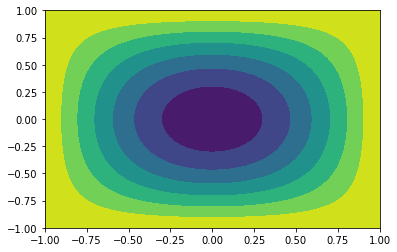

-0.20252146191115317


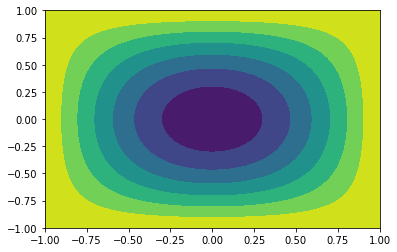

In [131]:
plt.contourf(xx,yy,u)
print(np.amin(u))
plt.show()
plt.contourf(xx,yy,usol(xx,yy))
print(np.amin(usol(xx,yy)))
plt.show()